In [21]:
import sys
import time
import warnings

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

Parse the Data

In [22]:
from utils import *

problem = 'lra'
case = 1
study = 6

print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")

Loading and formating the data...
Loading the data took 109.229371 s


KFold Cross Validation

In [42]:
from sklearn.model_selection import RepeatedKFold
from pyROMs.pod import POD

n_splits = 5
n_repeats = 500 // n_splits
interior_only = False

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

X = dataset.create_dataset_matrix(var)
Y = dataset.parameters

tau = 1.0e-8 if problem != 'lra' else 1.0e-10
if problem == 'three_group_sphere':
    interp = 'rbf_gaussian' if study == 0 else 'rbf'
    epsilon = 5.0 if study == 0 else 200.0
elif problem == 'infinite_slab':
    interp = 'rbf_gaussian'
    epsilon = 10.0
elif problem == 'twigl':
    interp = 'rbf_gaussian'
    epsilon = 20.0
else:
    interp = 'rbf_gaussian'
    epsilon = 200.0

cv = {'mean': [], 'max': [], 'min': [],
      'const_time': [], 'query_time': []}

peak = {'mean': [], 'max': [], 'min': []}

# Define the cross validator and iterator
print(f"Starting Repeated K-Fold cross-validation study...")
cross_validator = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
if interior_only:
    interior = dataset.interior_map
    iterator = cross_validator.split(X[interior], Y[interior])
else:
    iterator = cross_validator.split(X, Y)

# Perform the cross-validations
for train, test in iterator:
    if interior_only:
        boundary = dataset.boundary_map
        X_train, Y_train = X[interior][train], Y[interior][train]
        X_test, Y_test = X[interior][test], Y[interior][test]
        X_train = np.vstack((X_train, X[boundary]))
        Y_train = np.vstack((Y_train, Y[boundary]))
    else:
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]

    # Construct the ROM
    t_start = time.time()
    pod = POD(svd_rank=1.0-tau)
    pod.fit(X_train, Y_train, interp, epsilon=epsilon)
    t_end = time.time()
    cv['const_time'].append(t_end - t_start)

    # Predict the results
    t_start = time.time()
    X_pred = pod.predict(Y_test)
    t_end = time.time()
    cv['query_time'].append((t_end-t_start)/len(test))

    # Format datasets and compute errors
    X_pred = dataset.unstack_simulation_vector(X_pred)
    X_test = dataset.unstack_simulation_vector(X_test)
    errors = np.zeros(len(X_test))
    for i in range(len(X_test)):
        errors[i] = norm(X_test[i]-X_pred[i])/ norm(X_test[i])
    cv['mean'].append(np.mean(errors))
    cv['min'].append(np.min(errors))
    cv['max'].append(np.max(errors))

    peak_errors = np.zeros(len(X_test))
    for i in range(len(X_test)):
        argmax = np.argmax(np.sum(X_test[i], axis=1))
        peak_errors[i] = norm(X_test[i][argmax]-X_pred[i][argmax])
        peak_errors[i] /= norm(X_test[i][argmax])
    peak['mean'].append(np.mean(peak_errors))
    peak['max'].append(np.max(peak_errors))
    peak['min'].append(np.min(peak_errors))

print()
print(f"Number of POD Modes:\t\t{pod.n_modes}")
print(f"Number of Snapshots:\t\t{pod.n_snapshots}")
print(f"Number of Validations:\t\t{len(X_test)}")
print(f"Average Construction Time:\t{np.mean(cv['const_time']):.3e} s")
print(f"Average Query Time:\t\t{np.mean(cv['query_time']):.3e} s")

Starting Repeated K-Fold cross-validation study...

Number of POD Modes:		38
Number of Snapshots:		52
Number of Validations:		12
Average Construction Time:	2.067e-01 s
Average Query Time:		3.919e-04 s


Plot the Results

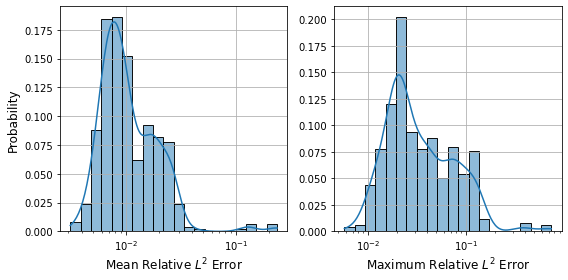

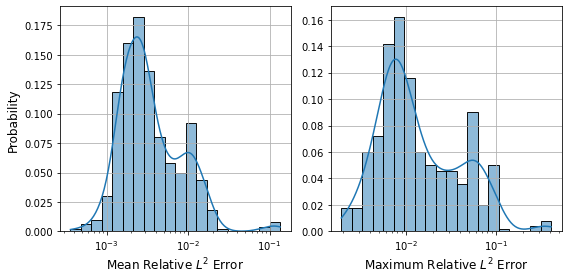

In [46]:
base = "/Users/zacharyhardy/Documents/phd/dissertation/dissertation/figures/"
if problem == 'three_group_sphere':
    base += "chapter6/"
elif problem == 'infinite_slab':
    base += "chapter7/"
elif problem == 'twigl':
    base += "chapter8/"
else:
    base += "chapter9/"

import seaborn as sb
from typing import List
from matplotlib.pyplot import Figure, Axes

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig: Figure = fig
axs: List[Axes] = axs.ravel()

for i, ax in enumerate(axs):
    data = cv['mean'] if i == 0 else cv['max']
    xlabel = "Mean " if i == 0 else "Maximum "
    ylabel = "Probability" if i == 0 else ""
    sb.histplot(data, bins=20, stat='probability',
                kde=True, log_scale=True, ax=ax)
    ax.set_xlabel(xlabel + "Relative $L^2$ Error", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)
plt.tight_layout()

if problem == 'three_group_sphere':
    base += "radius/" if study == 0 else "results_3d"
    if study == 3:
        base += "/" if var is None else "_power/"

filename = base + "error_distribution"
if interior_only:
    filename += "_interior"
plt.savefig(filename + ".pdf")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig: Figure = fig
axs: List[Axes] = axs.ravel()

for i, ax in enumerate(axs):
    data = peak['mean'] if i == 0 else peak['max']
    xlabel = "Mean " if i == 0 else "Maximum "
    ylabel = "Probability" if i == 0 else ""
    sb.histplot(data, bins=20, stat='probability',
                kde=True, log_scale=True, ax=ax)
    ax.set_xlabel(xlabel + "Relative $L^2$ Error", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)
plt.tight_layout()

filename = base + "peak_error_distribution"
if interior_only:
    filename += "_interior"
plt.savefig(filename + ".pdf")

Write LaTeX Table

In [44]:
msg = "\\begin{tabular}{|c|c|}" \
      "\n\t\hline" \
      "\n\t\\textbf{Quantity} & \\textbf{Value} \\\\ \hline"
msg += f"\n\t \hline Mean of Set Means & {np.mean(cv['mean']):.3e} \\\\"
msg += f"\n\t \hline Maximum of Set Means & {np.max(cv['mean']):.3e} \\\\"
msg += f"\n\t \hline Minimum of Set Means & {np.min(cv['mean']):.3e} \\\\"
msg += f"\n\t \hline Mean of Set Maximums & {np.mean(cv['max']):.3e} \\\\"
msg += f"\n\t \hline Maximum of Set Maximums & {np.max(cv['max']):.3e} \\\\"
msg += f"\n\t \hline Mean of Set Minimums & {np.mean(cv['min']):.3e} \\\\"
msg += f"\n\t \hline Minimum of Set Minimums & {np.min(cv['min']):.3e} \\\\"
msg += f"\n\t \hline \n \end{{tabular}}"
print(msg)


\begin{tabular}{|c|c|}
	\hline
	\textbf{Quantity} & \textbf{Value} \\ \hline
	 \hline Mean of Set Means & 1.394e-02 \\
	 \hline Maximum of Set Means & 2.356e-01 \\
	 \hline Minimum of Set Means & 3.121e-03 \\
	 \hline Mean of Set Maximums & 4.966e-02 \\
	 \hline Maximum of Set Maximums & 7.415e-01 \\
	 \hline Mean of Set Minimums & 1.541e-03 \\
	 \hline Minimum of Set Minimums & 1.759e-04 \\
	 \hline 
 \end{tabular}
